# Sentiment analysis media cloud extrated data

This notebook implements a foundational Sentiment Analysis pipeline on news titles, addressing the constraint of no labeled training data. We use the VADER lexicon method for classification and demonstrate feature engineering using TF-IDF and Truncated SVD (LSA) for future-proofing and exploration.

In [1]:
# Core Libraries
import pandas as pd
import re

# Sentiment Analysis (Lexicon)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Feature Extraction and Dimensionality Reduction (ML components)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# vizualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# --- Sample Newspaper Titles Data ---
media_cloud = pd.read_csv("data/mediacloud-2020-2025-dataset.csv") 
media_cloud.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url
0,1dc171e7750c319dc4a7b4ca87c8a6f5587c0e9481f129...,2025-11-03 00:22:19.404264+00:00,en,techcrunch.com,techcrunch.com,2025-11-02,Google pulls Gemma from AI Studio after Senato...,https://techcrunch.com/2025/11/02/google-pulls...
1,e6a47f0c7b6de768d799e603b5797ca432f9af6903de7b...,2025-11-02 23:17:22.553191+00:00,en,livemint.com,livemint.com,2025-11-02,Here's why India’s AI content draft rules miss...,https://www.livemint.com/opinion/online-views/...
2,8061d40a29f0fcf33e6906573a72389a4c0a0cc136522c...,2025-11-02 21:51:34.827292+00:00,en,apnews.com,apnews.com,2025-11-02,Who is Zico Kolter? A professor leads OpenAI s...,https://apnews.com/article/openai-safety-chatg...
3,d411e1a49c87e2e710c054d514f58beebcfa2f275107d8...,2025-11-02 20:26:57.088674+00:00,es,infolibre.es,infolibre.es,2025-11-02,"ChatGPT no es un psicólogo, pero cambiará su l...",https://www.infolibre.es/politica/chatgpt-rect...
4,c8ce06691fdf797a875be76c82efb7b0fab0d3d62a795c...,2025-11-02 20:17:51.246694+00:00,en,thestar.com,thestar.com,2025-11-02,"Like maple syrup and hockey, AI must become a ...",https://www.thestar.com/business/opinion/like-...


In [3]:
#since the dataset has not been tranlated we will filter for only english titles
media_cloud = media_cloud[media_cloud['language'] == 'en']

In [4]:
#let's conduct a sanity check on the data
print(media_cloud["language"].value_counts())

language
en    28928
Name: count, dtype: int64


# Preprocessing and Text Cleaning

In [5]:
def clean_text(text):
    # 1. Lowercasing (Standard practice for normalization)
    text = text.lower()
    # 2. Remove text inside parentheses (often non-essential context in titles)
    text = re.sub(r'\([^)]*\)', '', text)
    # 3. Remove most punctuation, but KEEP VADER-relevant symbols (like ! and ?)
    # VADER is explicitly designed to use punctuation (!!!) and capitalization (ALL CAPS)
    # as intensifiers. We will clean for the *TF-IDF* features but keep the raw
    # title for VADER, which is why we create a separate 'Clean_Title' column.
    return text

# We will create a clean version for feature extraction (TF-IDF)
media_cloud['clean_title'] = media_cloud['title'].apply(clean_text)


# Core Sentiment Classification (Lexicon-Based)

In [6]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    # Use the ORIGINAL 'Title' for VADER to leverage capitalization and punctuation
    return analyzer.polarity_scores(text)['compound']

def classify_sentiment(score):
    # Standard VADER thresholds
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

media_cloud['VADER_Compound_Score'] = media_cloud['title'].apply(get_vader_sentiment)
media_cloud['Sentiment_VADER'] = media_cloud['VADER_Compound_Score'].apply(classify_sentiment)

print("--- Sentiment Analysis Results (VADER) ---")
print(media_cloud[['title', 'VADER_Compound_Score', 'Sentiment_VADER']])

--- Sentiment Analysis Results (VADER) ---
                                                   title  \
0      Google pulls Gemma from AI Studio after Senato...   
1      Here's why India’s AI content draft rules miss...   
2      Who is Zico Kolter? A professor leads OpenAI s...   
4      Like maple syrup and hockey, AI must become a ...   
5      The professor leading OpenAI's safety panel ma...   
...                                                  ...   
35392  AI emerges as new tool for online scammers: Su...   
35393     Dealing with deepfakes: Regulation & education   
35394  New Delhi Slush’D witnessed unprecedented succ...   
35395                           AI on human rights watch   
35397  Musk ‘sensationalist’ comments on AI taking jo...   

       VADER_Compound_Score Sentiment_VADER  
0                   -0.3400        Negative  
1                   -0.1531        Negative  
2                    0.4215        Positive  
4                    0.3612        Positive  
5     

# Post-Classification Exploration and Feature Engineering

In [7]:
# Vectorize the CLEANED text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')
tfidf_matrix = vectorizer.fit_transform(media_cloud['clean_title'])
feature_names = vectorizer.get_feature_names_out()

print("TF-IDF Vectorization Complete.")
print(f"Shape of TF-IDF Matrix (Rows: Titles, Columns: Features): {tfidf_matrix.shape}")

TF-IDF Vectorization Complete.
Shape of TF-IDF Matrix (Rows: Titles, Columns: Features): (28928, 124260)


In [8]:
# Reduce dimensions to 2 components for ease of inspection
svd = TruncatedSVD(n_components=2, random_state=42)
lsa_result = svd.fit_transform(tfidf_matrix)

media_cloud['LSA_Component_1'] = lsa_result[:, 0]
media_cloud['LSA_Component_2'] = lsa_result[:, 1]

print("\n--- Exploration: LSA Components and Sentiment ---")
print(media_cloud[['Sentiment_VADER', 'LSA_Component_1', 'LSA_Component_2']])

# Look at the top features that define the discovered LSA components (the 'topics')
print("\nTop features defining the LSA Components (Inferred Topics):")
for i, comp in enumerate(svd.components_):
    # Get the top 5 words/n-grams that contribute most to this component
    sorted_idx = comp.argsort()[::-1][:5]
    top_words = [feature_names[j] for j in sorted_idx]
    print(f"Component {i+1}: {top_words}")


--- Exploration: LSA Components and Sentiment ---
      Sentiment_VADER  LSA_Component_1  LSA_Component_2
0            Negative         0.030815        -0.012733
1            Negative         0.055968        -0.016886
2            Positive         0.064913        -0.032610
4            Positive         0.032555        -0.013505
5            Positive         0.068994        -0.027918
...               ...              ...              ...
35392         Neutral         0.048279        -0.016797
35393         Neutral         0.032481        -0.013578
35394        Positive         0.018187        -0.003900
35395         Neutral         0.061244        -0.017238
35397         Neutral         0.051768        -0.020572

[28928 rows x 3 columns]

Top features defining the LSA Components (Inferred Topics):
Component 1: ['ai', 'safety', 'intelligence', 'artificial', 'artificial intelligence']
Component 2: ['artificial', 'intelligence', 'artificial intelligence', 'regulate artificial', 'extincti

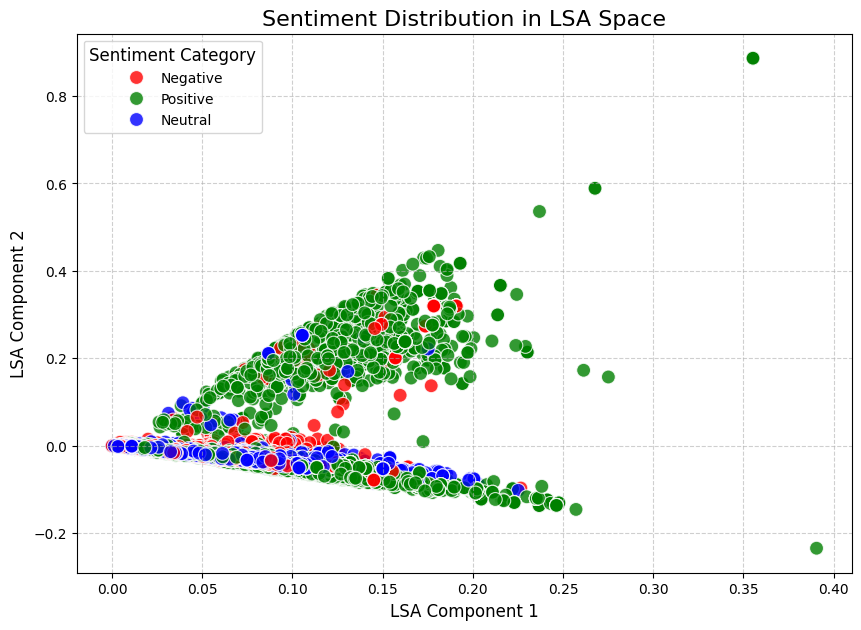

In [9]:
# 3. Visualization of LSA Components by Sentiment
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='LSA_Component_1',
    y='LSA_Component_2',
    hue='Sentiment_VADER',  # Color points by sentiment
    data=media_cloud,
    s=100, # Size of points
    alpha=0.8, # Transparency
    palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'} # Custom colors
)

# Add titles for clarity
plt.title('Sentiment Distribution in LSA Space', fontsize=16)
plt.xlabel('LSA Component 1', fontsize=12)
plt.ylabel('LSA Component 2', fontsize=12)

# Ensure the legend is displayed clearly
plt.legend(title='Sentiment Category', title_fontsize='12', fontsize='10')

plt.grid(True, linestyle='--', alpha=0.6)


plt.show()

In [12]:
# Create a DataFrame from the TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['Sentiment_VADER'] = media_cloud['Sentiment_VADER'].values

# Group by sentiment and compute mean TF-IDF scores
grouped_tfidf = tfidf_df.groupby('Sentiment_VADER').mean()

In [13]:
for sentiment in grouped_tfidf.index:
    top_words = grouped_tfidf.loc[sentiment].sort_values(ascending=False).head(10)
    print(f"\nTop TF-IDF words for {sentiment} sentiment:")
    print(top_words)



Top TF-IDF words for Negative sentiment:
ai         0.030776
risks      0.009628
openai     0.009117
risk       0.008292
warns      0.008277
tech       0.007161
eu         0.006700
chatgpt    0.006522
musk       0.006163
ban        0.006143
Name: Negative, dtype: float64

Top TF-IDF words for Neutral sentiment:
ai               0.032902
tech             0.008707
openai           0.008552
new              0.008517
regulation       0.007737
eu               0.007705
musk             0.006393
ai regulation    0.006190
trump            0.006025
says             0.006021
Name: Neutral, dtype: float64

Top TF-IDF words for Positive sentiment:
ai                         0.032795
safety                     0.018256
intelligence               0.016792
artificial                 0.016239
artificial intelligence    0.016026
ai safety                  0.014064
tech                       0.008075
summit                     0.007601
new                        0.007407
uk                         0.0